## 모든 모델 만든것 추가해서 Ensemble 
## 0과 1로 나온 결과만 넣고 평균 0.5 이상 -> 1
## 0.5 미만 -> 0

---

### 현재 모델 GM, BGM, LOF, AutoEncoder, Hotelling T2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [3]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')


In [4]:
result = pd.DataFrame(index = test.index ,columns=['gm','bgm','hotelling','LOF','autoencoder'], data=0)

In [5]:
te = test.drop(['type'], axis=1)
tr = train.drop(['type'], axis= 1)

In [6]:
ss = StandardScaler()

In [8]:
ss.fit(tr)

StandardScaler()

In [9]:
train_sc = ss.transform(tr)

In [10]:
test_sc = ss.fit_transform(te)

In [37]:
train_sc = pd.DataFrame(train_sc)
test_sc = pd.DataFrame(test_sc)

In [38]:
epsilon = 0.3
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(train_sc)

In [39]:
dbscan_test = DBSCAN(eps=epsilon, min_samples=min_samples).fit(test_sc)

In [40]:
labels = dbscan.fit_predict(train_sc)

In [41]:
train_sc = pd.DataFrame(train_sc)

In [42]:
train_sc['label'] = labels

In [43]:
train_sc[train_sc['label'] != -1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462],
           dtype='int64', length=2447)

In [44]:
train_sc = train_sc.loc[train_sc[train_sc['label'] != -1].index].drop('label', axis=1)

In [45]:
from sklearn.mixture import GaussianMixture

# GMM: n_components = 모델의 총 수
gm_1 = GaussianMixture(n_components=4, covariance_type = 'full',n_init=30, random_state=42)
gm_1.fit(train_sc)

GaussianMixture(n_components=4, n_init=30, random_state=42)

In [46]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=4, n_init=15, random_state=42)
bgm.fit(train_sc)
np.round(bgm.weights_, 2)

array([0.58, 0.15, 0.13, 0.14])

In [47]:
print(gm_1.converged_)
print(bgm.converged_)

True
True


In [48]:
densities = gm_1.score_samples(test_sc)
density_threshold = np.percentile(densities, 4)

In [49]:
bgm_densities = bgm.score_samples(test_sc)
bgm_density_threshold = np.percentile(bgm_densities, 4)

In [50]:
print(density_threshold)
print(bgm_density_threshold)

-240177.31266852847
-10814.563260488243


Text(0.5, 1.0, 'gmm result')

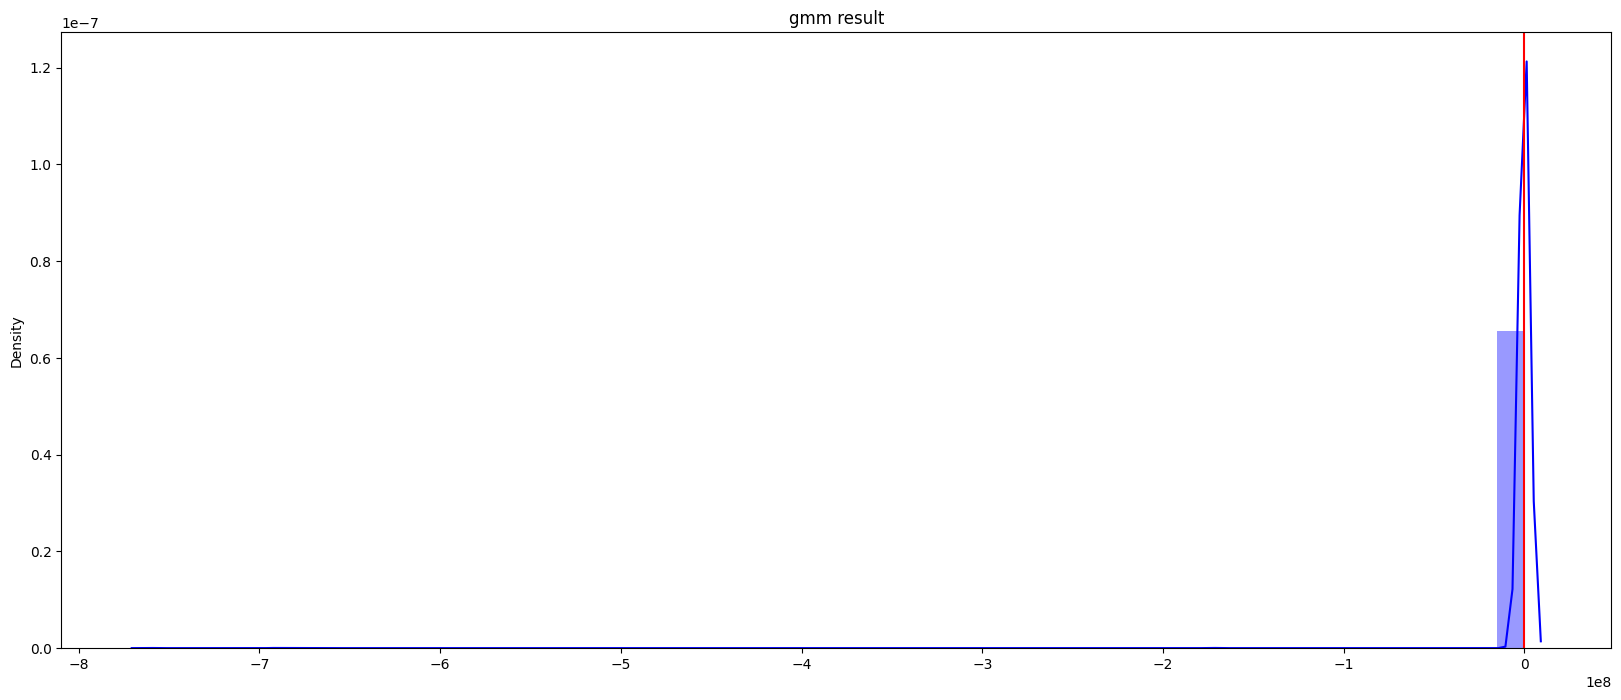

In [51]:
plt.figure(figsize=(20,8))
sns.distplot(densities, kde=True, color="b")
plt.axvline(density_threshold, color = 'red')
plt.title('gmm result')

Text(0.5, 1.0, 'bgm result')

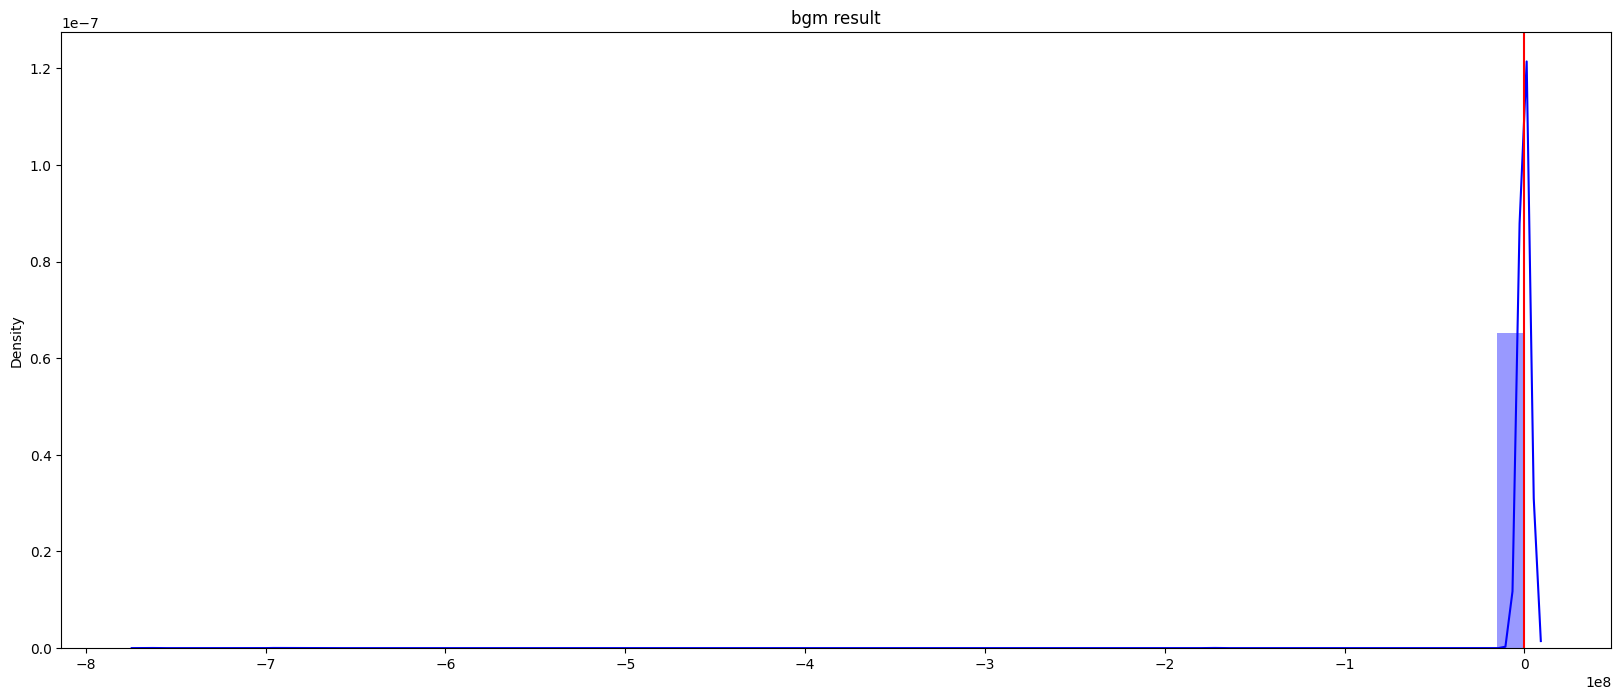

In [52]:
plt.figure(figsize=(20,8))
sns.distplot(bgm_densities, kde=True, color="b")
plt.axvline(bgm_density_threshold, color = 'red')
plt.title('bgm result')

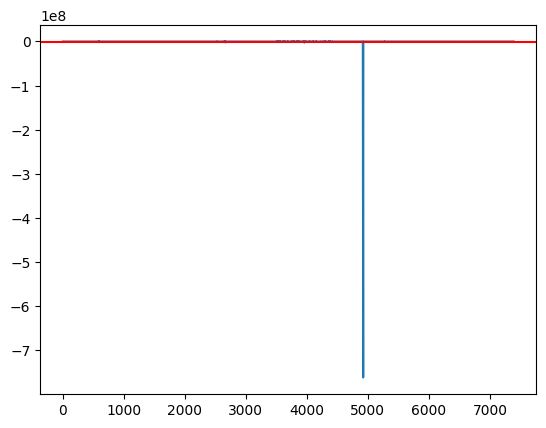

In [53]:
plt.plot(densities)
plt.axhline(density_threshold, color = 'r')
#plt.ylim(-90000,10)
plt.show()

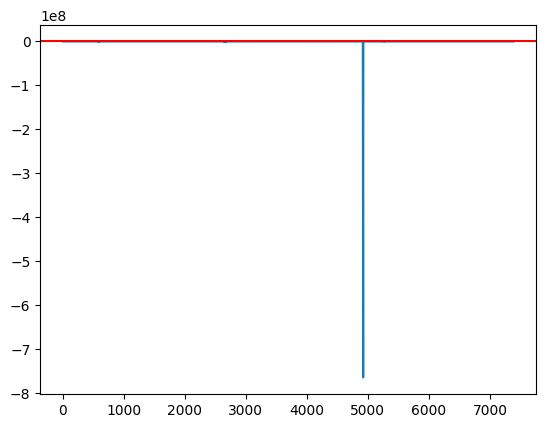

In [54]:
plt.plot(bgm_densities)
plt.axhline(bgm_density_threshold, color = 'r')
#plt.ylim(-2000,15)
plt.show()

In [55]:
anomalies = test_sc[densities < density_threshold]

In [56]:
bgm_anomalies = test_sc[bgm_densities < bgm_density_threshold]

In [57]:
anomalies

,0,1,2,3,4,5,6
586,-0.037055,0.334722,0.029701,0.319051,0.148584,-0.830857,0.364007
588,0.650278,1.714013,0.029701,1.243998,1.541652,-0.572491,1.186789
590,0.676053,1.761217,0.029701,1.275736,1.589639,-0.314125,1.217838
726,-0.028463,1.243120,0.029701,0.937194,0.717154,0.786516,1.310983
2643,-1.368763,1.248876,0.029701,-0.919501,1.537290,-0.788227,-0.210389
...,...,...,...,...,...,...,...
4920,0.478445,0.704298,-37.167516,0.526106,0.638630,0.709006,0.332958
4921,0.246470,0.303636,-37.167516,0.268421,0.232924,0.308538,0.100095
4922,-0.552555,-1.115952,-39.027377,-0.642168,-1.200860,-1.107309,-0.753736
4923,0.641686,1.002492,-39.027377,0.717292,0.939638,1.006127,0.519249


In [58]:
bgm_anomalies

,0,1,2,3,4,5,6
586,-0.037055,0.334722,0.029701,0.319051,0.148584,-0.830857,0.364007
588,0.650278,1.714013,0.029701,1.243998,1.541652,-0.572491,1.186789
590,0.676053,1.761217,0.029701,1.275736,1.589639,-0.314125,1.217838
591,-0.767346,-1.147038,0.029701,-0.675418,-1.349182,-0.184942,-0.536397
608,0.667461,1.743947,0.029701,1.264401,1.572189,1.630082,1.202314
...,...,...,...,...,...,...,...
6796,-1.050871,-0.939799,0.029701,-0.818996,-1.605111,-1.481940,-0.365631
6797,-0.458046,0.482092,0.029701,0.155825,-0.168419,-0.088054,0.472676
6798,-0.234663,1.028973,0.029701,0.530640,0.384155,0.457099,0.814208
6799,-0.097197,1.358252,0.029701,0.756587,0.717154,0.786516,1.000499


In [59]:
result.loc[anomalies.index.tolist(), 'gm'] = 1
result.loc[bgm_anomalies.index.tolist(), 'bgm'] = 1

---

## LOF

In [60]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [61]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.5)

In [62]:
param_grid = {'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28], 'contamination' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],}

In [63]:
clf = LocalOutlierFactor()

In [64]:
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid,
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2
                          )

In [65]:
grid_search.fit(train_sc)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=LocalOutlierFactor(), n_jobs=-1,
             param_grid={'contamination': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9],
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28]},
             scoring='accuracy', verbose=2)

In [66]:
grid_search.best_params_

{'contamination': 0.1, 'n_neighbors': 5}

In [67]:
clf2 = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

In [68]:
clf2.fit(train_sc)

LocalOutlierFactor(contamination=0.1, n_neighbors=5)

In [69]:
clf2.fit_predict(test_sc)

array([-1,  1,  1, ...,  1,  1,  1])

In [70]:
lof_score = clf2.negative_outlier_factor_

In [71]:
lof_threshold = np.percentile(lof_score, 3)

(-6.0, 0.5)

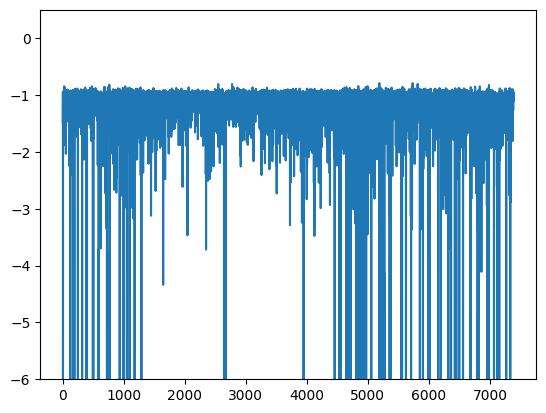

In [72]:
plt.plot(lof_score)
plt.ylim(-6,0.5)

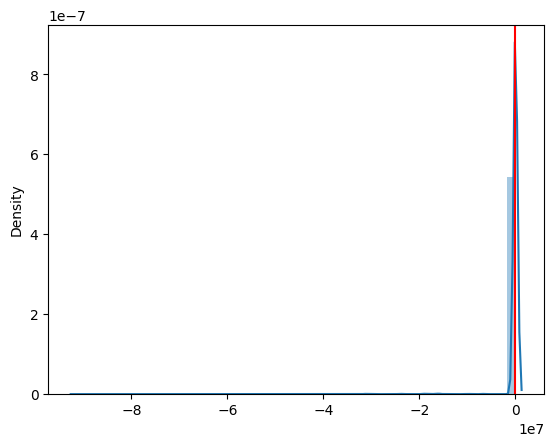

In [73]:
sns.distplot(lof_score)
plt.axvline(lof_threshold, color = 'r')
plt.show()

In [74]:
np.where(lof_score<lof_threshold)[0]

array([   3,  123,  125,  168,  177,  190,  248,  317,  387,  396,  493,
        500,  586,  587,  588,  589,  590,  591,  598,  621,  626,  664,
        700,  715,  717,  719,  721,  723,  724,  725,  726,  727,  769,
        841,  878,  887,  933,  951,  954,  957,  996, 1027, 1051, 1095,
       1137, 1152, 1177, 1277, 1288, 1317, 1446, 1521, 1645, 1677, 1963,
       2043, 2343, 2348, 2379, 2407, 2430, 2470, 2642, 2643, 2644, 2645,
       2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2656, 2657,
       2658, 2659, 2663, 2666, 2668, 2916, 3256, 3386, 3503, 3505, 3509,
       3723, 3732, 3734, 3790, 3901, 3919, 3940, 3941, 3942, 3943, 3944,
       3945, 3946, 3947, 3948, 3949, 3950, 3951, 3997, 4114, 4123, 4132,
       4154, 4195, 4226, 4230, 4373, 4378, 4455, 4530, 4553, 4643, 4675,
       4700, 4717, 4760, 4767, 4794, 4807, 4817, 4822, 4861, 4874, 4886,
       4893, 4917, 4918, 4931, 4971, 4994, 5041, 5054, 5055, 5086, 5107,
       5189, 5198, 5200, 5214, 5229, 5262, 5266, 52

In [75]:
result.loc[np.where(lof_score<lof_threshold)[0], 'LOF'] = 1

---

## AutoEncoder

In [76]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [77]:
input_dim = train_sc.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [78]:
autoencoder.fit(train_sc, train_sc, epochs=100, batch_size=50, shuffle=True)

Epoch 1/100
49/49 [==============================] - 1s 684us/step - loss: 1.0200
Epoch 2/100
49/49 [==============================] - 0s 625us/step - loss: 0.9339
Epoch 3/100
49/49 [==============================] - 0s 583us/step - loss: 0.8523
Epoch 4/100
49/49 [==============================] - 0s 646us/step - loss: 0.7764
Epoch 5/100
49/49 [==============================] - 0s 604us/step - loss: 0.7025
Epoch 6/100
49/49 [==============================] - 0s 604us/step - loss: 0.6183
Epoch 7/100
49/49 [==============================] - 0s 583us/step - loss: 0.5457
Epoch 8/100
49/49 [==============================] - 0s 621us/step - loss: 0.5016
Epoch 9/100
49/49 [==============================] - 0s 569us/step - loss: 0.4767
Epoch 10/100
49/49 [==============================] - 0s 591us/step - loss: 0.4613
Epoch 11/100
49/49 [==============================] - 0s 590us/step - loss: 0.4511
Epoch 12/100
49/49 [==============================] - 0s 577us/step - loss: 0.4436
Epoch 13/100


In [79]:
x_pred = autoencoder.predict(test_sc)
mse = np.mean(np.power(test_sc - x_pred, 2), axis=1)

231/231 [==============================] - 0s 478us/step


In [80]:
# 이상치 검출
auto_threshold = np.mean(mse) + 3*np.std(mse)
auto_outliers = np.where(mse > auto_threshold)[0]

In [81]:
auto_threshold

16.08411460790525

In [82]:
auto_outliers

array([4917, 4918, 4919, 4920, 4921, 4922, 4923], dtype=int64)

In [83]:
result.loc[auto_outliers, 'autoencoder'] = 1

In [84]:
result['label'] = result.mean(axis=1)

In [85]:
for i in range(len(result)):
    if result.label[i] > 0.5:
        result.label[i] = 1
    else:
        result.label[i] = 0

<AxesSubplot: >

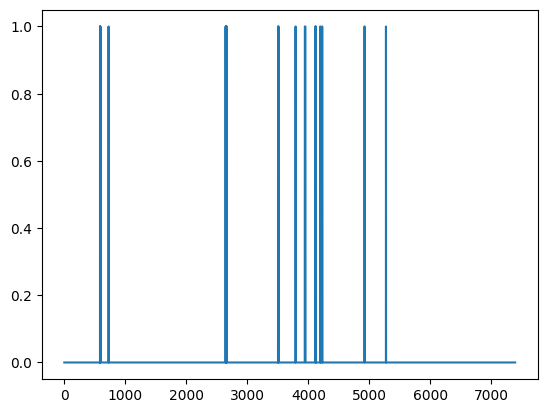

In [86]:
result.label.plot()

In [87]:
result.gm.value_counts()

0    7093
1     296
Name: gm, dtype: int64

<AxesSubplot: >

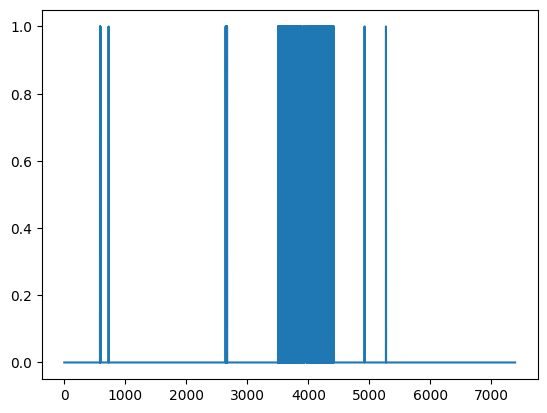

In [95]:
result.gm.plot()

In [88]:
result.bgm.value_counts()

0    7093
1     296
Name: bgm, dtype: int64

<AxesSubplot: >

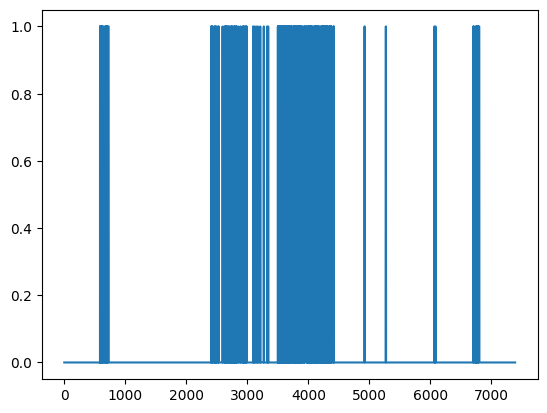

In [97]:
result.bgm.plot()

In [89]:
result.LOF.value_counts()

0    7167
1     222
Name: LOF, dtype: int64

In [90]:
result.hotelling.value_counts()

0    7389
Name: hotelling, dtype: int64

In [91]:
result.autoencoder.value_counts()

0    7382
1       7
Name: autoencoder, dtype: int64

result.to_csv('C:/Users/user/Desktop/result.csv', index=False)

In [92]:
result.label.value_counts()

0.0    7353
1.0      36
Name: label, dtype: int64

<AxesSubplot: >

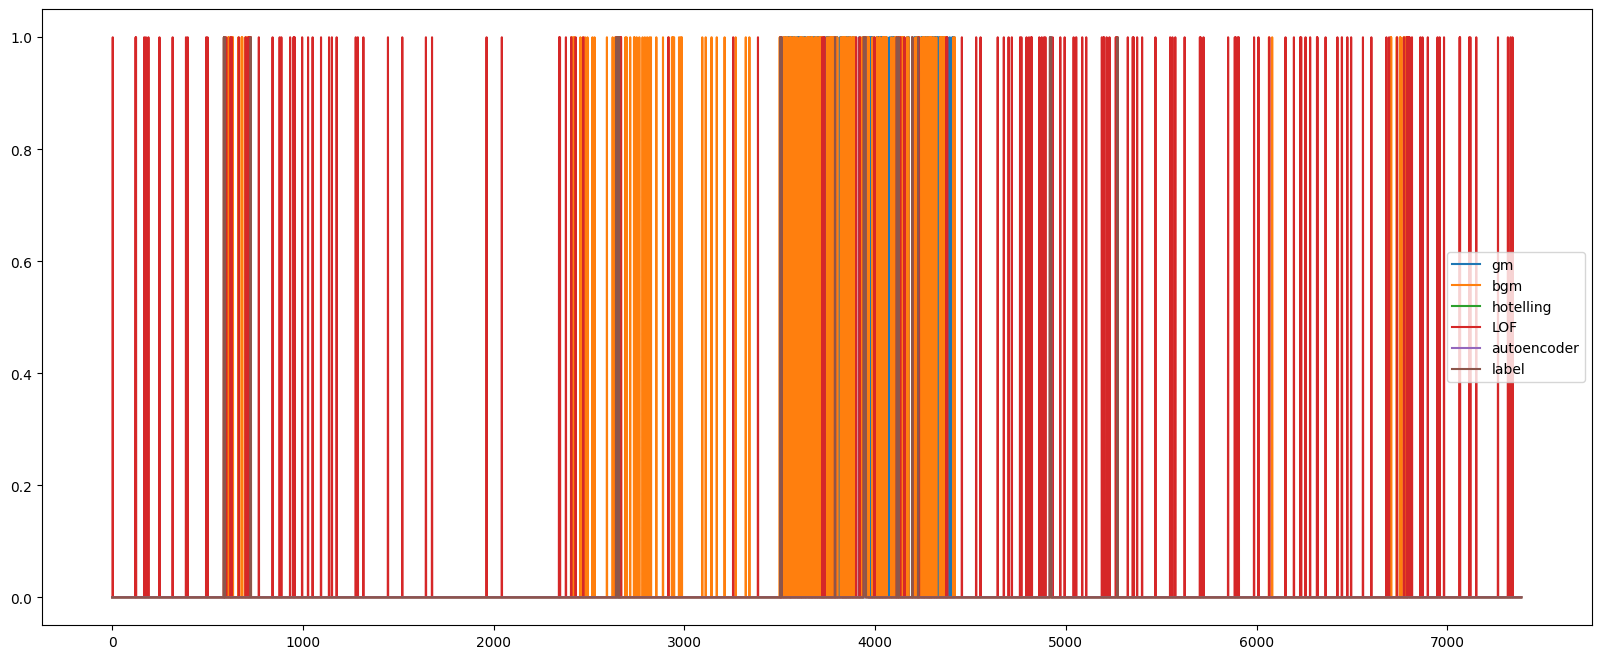

In [93]:
result.plot(figsize=(20,8))

<AxesSubplot: >

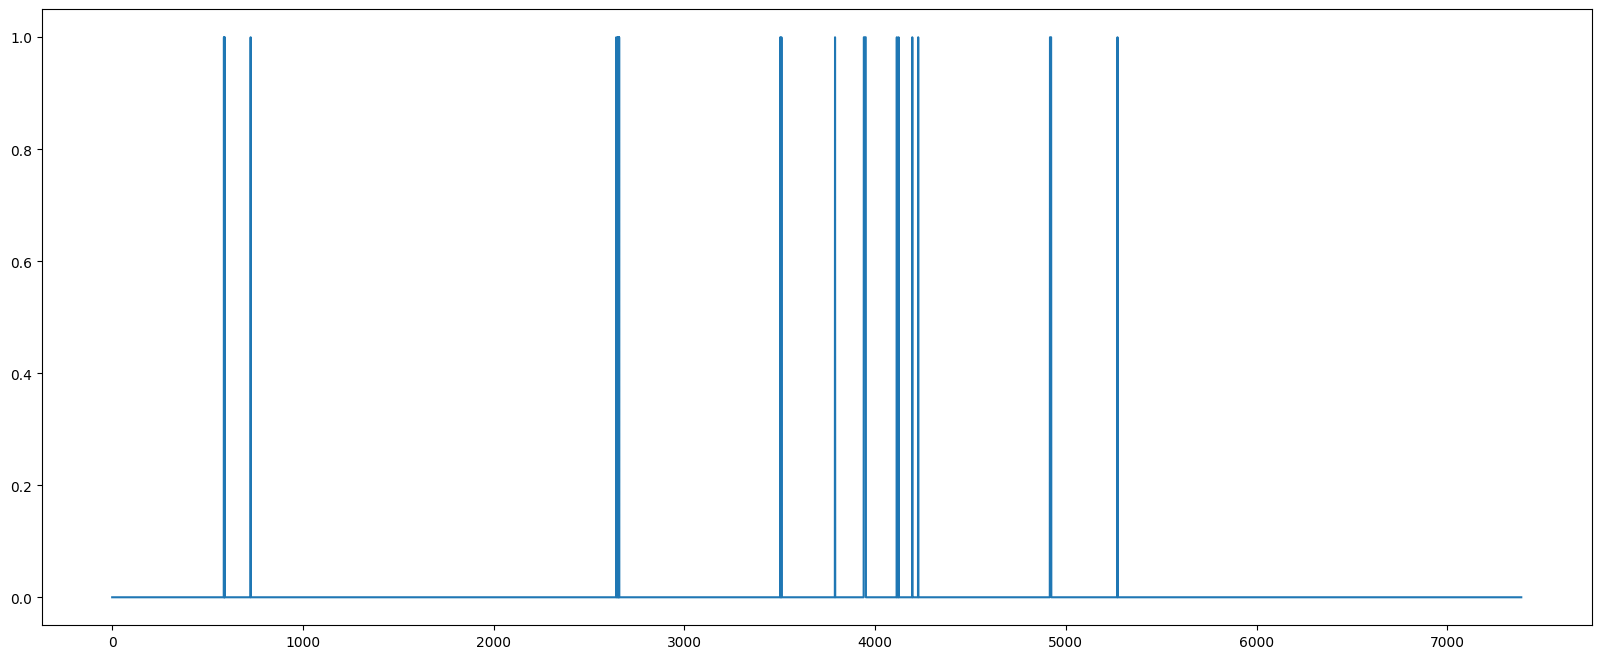

In [94]:
result.label.plot(figsize=(20,8))